# **Import Libarary**

In [81]:
# Manipulasi Data
import pandas as pd 
import numpy as np
import re
import string
import emoji
import csv
import requests
from io import StringIO
import time 

# Visualisasi Data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP & Preprocessing
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning & Sentiment Analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
# Download NLTK Resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagasnuryaman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagasnuryaman/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bagasnuryaman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bagasnuryaman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Loading Data**

In [3]:
# Membaca dataset
df = pd.read_csv('ff_scraping.csv')

# Menampilkan nya
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,169fd249-9e14-45b3-9fa5-b004f8792271,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sedih bgt njir, akun aku hilang ud level 40an",2,0,1.109.1,2025-05-20 21:30:40,NaN,NaN,1.109.1
1,a59942c7-c9b3-4ffd-a026-3589cbb5be3c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,game bayak buk bintang 1 Update terus buk nya ...,1,1,1.109.1,2025-05-20 21:29:45,NaN,NaN,1.109.1
2,1648cc00-59f2-4dcf-ac05-b974911f3aba,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,baguss gamenya,5,0,NaN,2025-05-20 21:22:48,NaN,NaN,NaN
3,b3e7444a-f50c-415a-b030-2eff43d394c9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ehh min lu klo ngasih tim yg ngotak apaa masa ...,1,0,1.109.1,2025-05-20 21:22:35,NaN,NaN,1.109.1
4,66863758-112b-4c94-b583-47b7306f0a6c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus banget game nya,5,0,NaN,2025-05-20 21:19:35,NaN,NaN,NaN


# **Data Preprocessing**

In [4]:
# Menampilkan informasi dari dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  6508 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          7 non-null      object
 9   repliedAt             7 non-null      object
 10  appVersion            6508 non-null   object
dtypes: int64(2), object(9)
memory usage: 859.5+ KB


- Bisa kita lihat ada `Missing Values` pada fitur **reviewCreatedVersion**, **replyContent**, **repliedAt**, dan juga **appVersion**. 
- Disini aku bakal mengambil fitur **Score** dan juga **Content** saja.

## **Mengambil fitur yang akan digunakan saja**

In [5]:
ff_clean = df[['score', 'content']].copy()

## **Penanganan Missing Values**

In [6]:
# Menampilkan Fitur yang missing values
missing_values = ff_clean.isnull().sum()
missing_values_percentage = (missing_values / len(ff_clean)) * 100
missing_values_ff_clean = pd.DataFrame({'Jumlah Missing Values': missing_values, 'Persentase': missing_values_percentage})
print(f'Keseluruhan Missing Values dari dataset ff_clean ini adalah {ff_clean.isnull().sum().sum()}')

# Cek hasil
missing_values_ff_clean

Keseluruhan Missing Values dari dataset ff_clean ini adalah 0


,Jumlah Missing Values,Persentase
score,0,0.0
content,0,0.0


- Soleh Juga gak ada missing values nya.

## **Penanganan Duplikasi Data**

In [7]:
print(f'Jumlah data yang terkena duplikasi data adalah : {ff_clean.duplicated().sum()}')

Jumlah data yang terkena duplikasi data adalah : 1776


- Disini akan aku hapus saja.

In [8]:
ff_clean.drop_duplicates(inplace=True)
print(f'Jumlah data yang terkena duplikasi data adalah : {ff_clean.duplicated().sum()}')

Jumlah data yang terkena duplikasi data adalah : 0


## **Preprocessing Text**

### **Cleaning Text**

In [9]:
# ----- 1. Cleaning Text ------
def clean_text(text):
    """
    Fungsi untuk membersihkan teks dari karakter karakter yang tidak di inginkan seperti angka, simbol, emoji, url, karakter khusus dll.
    """
    text = re.sub(r'@\w+', '', text) # Menghapus mention
    text = re.sub(r'#(\w+)', r'\1', text) # Menghapus hashtag
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Menghapus URL
    text = re.sub(r'\bRT\b', '', text) # Menghapus RT
    text = re.sub(r'\d+', '', text) # Menghapus angka
    text = re.sub(r'\s+', ' ', text) # Menghapus whitespace berlebih
    
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # Menghapus tanda baca
    text = text.strip() # Menghapus whitespace di awal dan akhir

    # Menghapus emoji
    text = emoji.replace_emoji(text, replace='')
    return text

- Langkah awal untuk `Preprocessing Text` adalah dengan cara membersihkan text dari karakter karakter yang tidak di inginkan seperti angka, emoji, url, simbol, karakter khusus, tanda baca, dll. Makanya itu aku membuat fungsi **`clean_text`**.

### **Case Folding**

In [10]:
# ----- 2. Case Folding -----
def case_folding(text):
    """
    Fungsi untuk mengubah teks menjadi huruf kecil
    """
    return text.lower()

- Langkah keduanya yaitu membuat text atau kalimat kalimat menjadi huruf kecil, karena dalam NLP ini di haruskan banget seragam, maka dari itu aku membuat fungsi **`case_folding`**.

### **Slang Words**

In [11]:
# ----- 3. Normalisasi Slang Words -----
def normalize_slang(text):
    """
    Fungsi untuk menormalkan kata kata slang/informal menjadi kata baku
    """
    # Kamus slang words untuk Free Fire
    slang_dict = {
        # Game-specific
        'ff': 'free fire', 'epep': 'free fire', 'dm': 'diamond', 'daimen': 'diamond', 'daymen': 'diamond', 'daimon': 'diamond', 'gem': 'game', 'geme': 'game', 'gm': 'game', 'boyah': 'menang', 'mabar': 'main bareng', 'cs': 'clash squad', 'br': 'battle royale', 'citer': 'cheater', 'chiter': 'cheater', 'bewan': 'bermain', 'bundel': 'bundle', 'bandle': 'bundle', 'sg': 'shotgun', 'rank': 'peringkat', 'reng': 'rank', 'renk': 'rank', 'hedsot': 'headshot','hetsot': 'headshot', 'glowal': 'gloo wall', 'gllowal': 'gloo  wall', 'bag': 'bug', 'buk': 'bug', 'afk': 'meninggalkan permainan', 'gg' : 'good game', 'ggwp': 'good game well played', 'gege': 'good game', 'setep': 'step', 'sensi': 'sensitivitas kontrol', 'bot': 'pemain yang tidak handal', 'apdet': 'update', 'apdetan': 'update', 'even': 'event', 'top up': 'isi ulang diamong', 'gameplay': 'cara bermain', 'win': 'menang', 'lose': 'kalah', 'los': 'kalah', 'reload': 'isi ulang peluru', 'damage': 'kerusakan', 'kentang': 'handphone jelek', 'demek': 'damage', 'geme': 'game', 'gem': 'game', 'gamr': 'game', 'mL': 'Mobile Legends', 'ml': 'Mobile Legends', 'santino': 'karakter santino', 'mb': 'megabyte', 'patah patah': 'lag', 'gerafik': 'grafik', 'hetsot': 'headshot', 'prime': 'masa masa jago', 'Ben': 'banned', 'cit': 'cheater', 'match': 'permainan', 'cheater': 'pemain curang', 'chet': 'pemain curang', 'cheat' : 'pemain curang', 'mainin': 'main', 'gegaca': 'gacha', 'yepin': 'ngespin', 'bandel': 'bundle', 'bundle': 'paket', 'toap': 'top up', 'bak': 'bug','nge firzz' : 'lag', 'ngelek': 'lag', 'rangket': 'ranked', 'ranket': 'ranked', 'ranket': 'ranked', 'gameee': 'game', 'gim': 'game', 'war': 'perang', 'iven': 'event', 'kenok': 'knockout', 'games': 'game', 'bl': 'blacklist', 'free frie': 'free fire', 'pus': 'push',  'cs': 'clash squad', 'dem': 'diamond', 'eff': 'free fire', 'abdet': 'update', 'gaca': 'gacha', 'geam': 'game', 

        # Kata Kata Umum, singkatan dan juga typo
        'gw': 'saya', 'gue': 'saya', 'aku': 'saya', 'lu': 'kamu', 'lo': 'kamu', 'aja': 'saja', 'aj': 'saja', 'kalo': 'kalau', 'klo': 'kalau', 'klu': 'kalau',  'bgt': 'banget', 'yg': 'yang', 'ga': 'tidak', 'gak': 'tidak', 'gk': 'tidak', 'ngga': 'tidak', 'nggak': 'tidak', 'udah': 'sudah', 'udh': 'sudah','dah': 'sudah', 'nih': 'ini', 'emg': 'memang', 'emang': 'memang', 'kyk': 'seperti', 'kyak': 'seperti', 'kek': 'seperti', 'dgn': 'dengan', 'sm': 'sama', 'tp': 'tapi', 'tpi': 'tapi', 'pake': 'pakai', 'pakek': 'pakai','ngelag': 'lag', 'nglag': 'lag', 'leg': 'lag', 'burik': 'grafiknya jelek', 'bgus': 'bagus', 'bgs': 'bagus', 'baguss': 'bagus', 'mantep': 'mantap', 'mantap': 'sangat bagus', 'seru': 'menyenangkan', 'yah': 'ya', 'krn': 'karena', 'min': 'admin', 'plis': 'tolong', 'pliss': 'tolong', 'tlg': 'tolong', 'jgn': 'jangan', 'bocil': 'anak kecil', 'ud': 'sudah', 'maen': 'main', 'ngasih': 'memberi', 'ngotak': 'masuk akal', 'mulu': 'terus', 'stuk': 'terjebak', 'ganiat': 'tidak niat', 'gausah': 'tidak usah', 'di bukan': 'di buka', 'ngebantu': 'membantu', 'pingin': 'ingin', 'mlah': 'malah', 'dapet': 'dapat', 'mayan': 'lumayan', 'effort': 'usaha', 'berdamage': 'berdampak', 'kasih': 'beri', 'yok': 'ayo', 'yuk': 'ayo', 'comeback': 'kembali', 'apus': 'hapus', 'kayak': 'seperti', 'jir': 'aduh', 'njir': 'aduh', 'anjir': 'aduh', 'hoki': 'keberuntungan', 'smoth': 'halus', 'smooth': 'halus', 'smpai': 'sampai', 'smp': 'sampai', 'smpe': 'sampai', 'sampe': 'sampai', 'hamdeh': 'aduh', 'gak': 'tidak', 'tolol': 'bodoh', 'bodo': 'bodoh', 'moga': 'semoga', 'ngeleg': 'lag', 'karna' : 'karena', 'MLah': 'malah', 'even': 'event', 'event': 'acara', 'sanat': 'sana', 'kayae': 'seperti', 'kaya': 'seperti', 'kya': 'seperti', 'kyae': 'seperti', 'kentang': 'jelek', 'HP': 'handphone', 'masi': 'masih', 'setiah': 'setia', 'kengan' : 'kenangan', 'keluarin': 'mengeluarkan', 'gk': 'tidak', 'nggk': 'tidak', 'ga' : 'tidak', 'bnyk': 'banyak', 'kasi': 'beri', 'ny': 'nya', 'zeru': 'seru', 'banyakk': 'banyak', 'mental': 'terlempar', 'lian' : 'lain', 'turunni': 'turunin', 'plisss': 'tolong', 'ae': 'saja', 'pensi': 'vakum', 'ya': 'nya', 'guwa': 'saya', 'dongo': 'bodoh', 'amat': 'sangat', 'yt': 'youtube', 'patah': 'lag', 'kaga': 'tidak', 'su': 'goblok', 'dri': 'dari', 'pensii': 'vakum', 'terjebak': 'terjelek', 'hanam': 'haram', 'bgke': 'bangke', 'kntl': 'kontol', 'mlu' : 'mulu', 'mulu': 'terus', 'gaada': 'gak ada', 'batu': 'baju', 'susahin': 'menyusahkan', 'uwang': 'uang', 'mininggal': 'meninggal', 'kuren': 'keren', 'anjg': 'anjing', 'kalo': 'kalau', 'jetemu': 'ketemu', 'booooot': 'bot', 'bot': 'pemain Ai', 'sya': 'saya', 'mud': 'mood', 'iclik': 'licik', 'salakan': 'salahkan', 'trimakasi': 'terimakasih', 'knp': 'kenapa', 'mw': 'mau', 'bok': 'bot', 'sip': 'bagus', 'merah': 'murah', 'pulak': 'pula', 'geratis': 'gratis', 'bg': 'bang', 'ad': 'ada', 'gwh': 'saya', 'kenaben': 'ke banned', 'totong': 'tolong', 'langsun': 'langsung', 'lgi': 'lagi', 'g': 'tidak', 'manuk': 'masuk', 'gua': 'saya', 'mh': 'mah', 'old': 'dulu', 'samph' : 'sampah', 'kikir': 'pelit', 'kandang': 'kadang', 'sampek': 'sampai', 'tebel': 'tebal', 'iklas': 'ikhlas', 'kek': 'seperti', 'curi': 'mencuri', 'mlh': 'malah', 'kyk': 'seperti', 'bnggt': 'banget', 'ngebak' : 'bug', 'gra fiknya': 'grafiknya', 'gimna': 'bagaimana', 'gmn': 'bagaimana', 'gimn': 'bagaimana', 'taik': 'tai', 'mening': 'mendingan', 'gra gra': 'gara gara', 'bgt': 'banget', 'ultah': 'ulang tahun', 'ajah': 'saja', 'defloper': 'developer', 'kukasi': 'aku beri', 'bitang': 'bintang', 'kn': 'kan', 'pin': 'ingin', 'ploplayer': 'proplayer', 'proplayer': 'pemain pro', 'jga': 'juga', 'baywan': 'by one', 'by one': 'satu lawan satu', 'bkn': 'bukan', 'don': 'dong', 'knapa': 'kenapa', 'kebalikan': 'kembalikan', 'kau': 'kamu', 'kalaw': 'kalau', 'donlod': 'download', 'donlot': 'download', 'donload': 'download', 'donlod': 'download', 'donlot': 'download', 'donloud': 'download', 'donloud': 'download', 'bet': 'banget', 'collab' : 'kolaborasi', 
    }
    
    # Membuat kata kata menjadi lowercase
    words = text.lower().split()
    
    # Normalisasi setiap kata
    normalized_words = []
    for word in words:
        # Jika kata ada dalam kamus slang, ganti dengan kata bakunya
        if word in slang_dict:
            normalized_words.append(slang_dict[word])
        else:
            normalized_words.append(word)
    
    # Gabungkan kembali kata-kata menjadi teks
    return ' '.join(normalized_words)


- Langkah ketiga adalah kita harus mengganti kata kata yang informal seperti singkatan, dan bahasa gaul menjadi kata kata yang baku, dan juga pasti ada typo nah kita juga harus membersihkan dan mengganti dengan kalimat atau kata kata yang benar, makanya dari itu aku bikin sebuah fungsi yang bernama **`normalize_slang`**.

> **ANNOUNCEMENT**

- Tapi yang perlu garis bawahi adalah kata kata typo dan slangwords ini pasti banyak, aku hanya mencoba untuk mengganti beberapa kata kata yang umum digunakan, karena keterbatasan waktu dan aku adalah manusia tidak mungkin untuk satu satu melihat review dan mengganti kata kata yang typo atau slangwordsnya.

### **Tokenization**

In [12]:
# ----- 4. Tokenization -----
def tokenization(text):
    """
    Fungsi untuk mmemecah teks atau membagi teks menjadi daftar akata atau token
    """
    token = word_tokenize(text)
    return token

- Langkah ke 4 adalah kita harus memecah teks atau kalimat menjadi daftar kata atau token yang bermakna, ini langkah yang harus di lakukan karena kalau tidak kita tidak bisa melanjutkan ke langkah berikutnya. 

### **StopWords**

In [13]:
# ----- 5. Stopword Removal -----
def filtering_stopwords(tokens):
    """
    Fungsi untuk mengganti kata kata umum yang kurang bermakna dari daftar token
    """
    listStopWords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    custom_stopwords = [
        'iya', 'yaa', 'gak', 'nga', 'gk', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 
        'gaa', 'loh', 'kah', 'woi', 'woii', 'woy', 'dong', 'deh', 'nih', 'sih',
        'kok', 'kek', 'cuma', 'doang', 'banget', 'aja', 'doank', 'bgt', 'yg', 'udah',
        'udh', 'dah', 'tuh', 'gitu', 'gini', 'emang', 'emg', 'kan', 'kalo', 'klo',
        'yah', 'si', 'tau', 'gw', 'gue', 'ane', 'lu', 'lo', 'wkwk', 'wkwkwk', 'xixi',
        'haha', 'hehe', 'tp', 'tapi', 'karna', 'krn', 'biar', 'ehh', 'eh'
    ]

    ff_stopwords = [
    'ff', 'freefire', 'free', 'fire', 'garena', 'game', 'player', 'play', 'main',
    'maen', 'mainkan', 'bermain', 'pemain', 'char', 'character', 'karakter',
    'season', 'ranked', 'classic', 'match', 'skin', 'diamond', 'dm'
]
    listStopWords.update(ff_stopwords)
    listStopWords.update(custom_stopwords)
    listStopWords.update(listStopwords1)
    filtered = []
    for txt in tokens:
        if txt not in listStopWords:
            filtered.append(txt)
    tokens = filtered
    return tokens

- Pada tahapan ke 5 ini, kita harus mencari kata kata yang umum dan sering muncul dalam teks atau sutau kalimat tapi tidak bermakna dan tidak berkontribusi apapun di dalam hasil pemodelan. Contohnya kata **dan**, **yang**, **di** dll. Jadi intinya seperti ini aja deh, Menghapus kata kata yang tidak relevan agar analisis menjadi lebih fokus pada kata kata yang bermakna.

### **Stemming**

In [14]:
# ----- 6. Stemming -----
def stemming(tokens):
    """
    Fungsi untuk mengubah daftar kata atau token menjadi bentuk dasarnya menggunakan Sastrawi karena bahasa Indonesia
    """
    # Membuat objek stemmer 
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Melakukan stemming pada setiap token dengan list comprehension
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

- Langkah ke 6 adalah `Stemming`, berfungsi untuk menyederhanakan kata ke bentuk dasarnya, agar model bisa memahami teks dengan lebih efisien dan akurat.

### **Joining**

In [15]:
# ----- 7. Join Tokens to Text -----
def to_sentence(tokens):
    """
    Fungsi untuk menggabungkan token menjadi kalimat
    """
    return " ".join(tokens)


- Langkah terakhir adalah menggabungkan daftar kata kata menjadi sebuah kalimat utuh lagi, karena tadi kan kita pecah pecah, dan terakhir digabungkan kembali.

### **Penerapan Function**

In [16]:
def preprocessing_text(dataset):
    """
    Menerapkan pipeline preprocessing text pada dataset dengan analisis missing values.
    """

    df = dataset.copy()
    total_data = len(df)

    print(f'Memulai preprocessing untuk {total_data} data ulasan Free Fire\n')
    
    # Fungsi untuk memeriksa dan melaporkan missing values
    def check_missing(df, column_name):
        missing = df[column_name].isna().sum()
        empty = (df[column_name].astype(str) == '').sum()
        total_invalid = missing + empty
        percent = (total_invalid / len(df)) * 100
        
        print(f'Status data: {len(df)-total_invalid} valid, {total_invalid} missing/empty ({percent:.2f}%)')
        return total_invalid

    try:
        # 1. Cleaning Text
        df['clean_text'] = df['content'].apply(clean_text)
        check_missing(df, 'clean_text')
        print(f'Proses Cleaning Text done Mamang!!!\n')

        # 2. Case Folding
        df['case_foldingText'] = df['clean_text'].apply(case_folding)
        check_missing(df, 'case_foldingText')
        print(f'Proses Case Folding done Mamang!!!\n')

        # 3. Normalisasi Slang Words 
        df['normalized_slangwordsText'] = df['case_foldingText'].apply(normalize_slang)
        check_missing(df, 'normalized_slangwordsText')
        print(f'Proses Normalisasi Slang Words done Mamang!!!\n')

        # 4. Tokenizing
        df['tokenized_text'] = df['normalized_slangwordsText'].apply(tokenization)

        # Untuk kolom list, periksa list kosong
        tokenize_empty = sum(1 for x in df['tokenized_text'] if not x)
        print(f'Status data: {len(df)-tokenize_empty} valid, {tokenize_empty} empty lists ({tokenize_empty/len(df)*100:.2f}%)')
        print(f'Proses Tokenizing done Mamang!!!\n')

        # 5. Stopword Removal
        df['stopword_removedText'] = df['tokenized_text'].apply(filtering_stopwords)
        stopword_empty = sum(1 for x in df['stopword_removedText'] if not x)
        print(f'Status data: {len(df)-stopword_empty} valid, {stopword_empty} empty lists ({stopword_empty/len(df)*100:.2f}%)')
        print(f'Proses Stopword Removal done Mamang!!!\n')

        # 6. Stemming
        df['stemmed_text'] = df['stopword_removedText'].apply(stemming)
        stemming_empty = sum(1 for x in df['stemmed_text'] if not x)
        print(f'Status data: {len(df)-stemming_empty} valid, {stemming_empty} empty lists ({stemming_empty/len(df)*100:.2f}%)')
        print(f'Proses Stemming done Mamang!!!\n')

        # 7. Join Tokens to Text
        df['final_text'] = df['stemmed_text'].apply(to_sentence)
        final_missing = check_missing(df, 'final_text')
        print(f'Proses Join Tokens to Text done Mamang!!!\n')

        # Ringkasan hasil preprocessing
        print('RINGKASAN HASIL PREPROCESSING:')
        print(f'Total data awal: {total_data}')
        print(f'Total data valid setelah preprocessing: {total_data - final_missing}')
        print(f'Total data invalid/kosong: {final_missing} ({final_missing/total_data*100:.2f}%)')
        
        # Analisis data yang hilang di tahap akhir (opsional)
        if final_missing > 0:
            print('\nAnalisis data kosong:')
            empty_indices = df[df['final_text'] == ''].index
            for idx in empty_indices[:min(3, len(empty_indices))]:
                print(f'\nData kosong #{idx}:')
                print(f'Teks asli: {df["content"].iloc[idx]}')
                print(f'Setelah cleaning: {df["clean_text"].iloc[idx]}')
                
        print(f'\nPREPROCESSING SELESAI MAMANG!')
        
    except Exception as e:
        print(f'\nWalawe Terjadi error pada preprocessing Mamang: {str(e)}')
        
    return df

In [17]:
# Implementasi Function
process_df = preprocessing_text(ff_clean)
process_df.head()

Memulai preprocessing untuk 8224 data ulasan Free Fire

Status data: 8155 valid, 69 missing/empty (0.84%)
Proses Cleaning Text done Mamang!!!

Status data: 8155 valid, 69 missing/empty (0.84%)
Proses Case Folding done Mamang!!!

Status data: 8154 valid, 70 missing/empty (0.85%)
Proses Normalisasi Slang Words done Mamang!!!

Status data: 8154 valid, 70 empty lists (0.85%)
Proses Tokenizing done Mamang!!!

Status data: 8042 valid, 182 empty lists (2.21%)
Proses Stopword Removal done Mamang!!!

Status data: 8042 valid, 182 empty lists (2.21%)
Proses Stemming done Mamang!!!

Status data: 8037 valid, 187 missing/empty (2.27%)
Proses Join Tokens to Text done Mamang!!!

RINGKASAN HASIL PREPROCESSING:
Total data awal: 8224
Total data valid setelah preprocessing: 8037
Total data invalid/kosong: 187 (2.27%)

Analisis data kosong:

Data kosong #17:
Teks asli: ⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐😼⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐💛⭐⭐⭐⭐⭐⭐⭐⭐😼⭐⭐😼⭐🌛⭐⭐😼⭐😼⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐🌟⭐⭐⭐⭐⭐⭐🌟⭐⭐⭐⭐⚡⭐⭐⭐⭐⭐⭐🎊⭐⭐⭐⭐⭐⭐💛⭐⭐⭐⭐⭐⭐⭐⭐⭐🌝⭐⭐⭐⭐🌛⭐⭐⭐🕳️🌜⭐⭐⭐⭐⭐⭐⭐

,score,content,clean_text,case_foldingText,normalized_slangwordsText,tokenized_text,stopword_removedText,stemmed_text,final_text
0,2,"sedih bgt njir, akun aku hilang ud level 40an",sedih bgt njir akun aku hilang ud level an,sedih bgt njir akun aku hilang ud level an,sedih banget aduh akun saya hilang sudah level an,"[sedih, banget, aduh, akun, saya, hilang, suda...","[sedih, aduh, akun, hilang, level]","[sedih, aduh, akun, hilang, level]",sedih aduh akun hilang level
1,1,game bayak buk bintang 1 Update terus buk nya ...,game bayak buk bintang Update terus buk nya ng...,game bayak buk bintang update terus buk nya ng...,game bayak bug bintang update terus bug nya ti...,"[game, bayak, bug, bintang, update, terus, bug...","[bayak, bug, bintang, update, bug, perbaiki, b...","[bayak, bug, bintang, update, bug, baik, bug, ...",bayak bug bintang update bug baik bug damage p...
2,5,baguss gamenya,baguss gamenya,baguss gamenya,bagus gamenya,"[bagus, gamenya]","[bagus, gamenya]","[bagus, gamenya]",bagus gamenya
3,1,ehh min lu klo ngasih tim yg ngotak apaa masa ...,ehh min lu klo ngasih tim yg ngotak apaa masa ...,ehh min lu klo ngasih tim yg ngotak apaa masa ...,ehh admin kamu kalau memberi tim yang masuk ak...,"[ehh, admin, kamu, kalau, memberi, tim, yang, ...","[admin, tim, masuk, akal, apaa, clash, squad, ...","[admin, tim, masuk, akal, apaa, clash, squad, ...",admin tim masuk akal apaa clash squad elite ti...
4,5,bagus banget game nya,bagus banget game nya,bagus banget game nya,bagus banget game nya,"[bagus, banget, game, nya]",[bagus],[bagus],bagus


- Dan alhamdulillah hasilnya lancar dan aman ya, tapi masalahnya disini ada missing values nih setelah kita melakukan preprocessing kepada text, kemungkinan ini adalah emoji emoji yang di replace menjadi nilai yang kosong, maka dari itu kita akan menghapusnya saja.

In [18]:
# Menghapus data yang missing values
def clean_missing_values(dataset):
    """
    Fungsi untuk menghapus baris dengan missing values pada kolom final_text atau score
    dan menampilkan informasi tentang data yang dihapus
    """
    print('MEMBERSIHKAN DATA DARI MISSING VALUES')
    
    # Simpan jumlah data awal
    total_awal = len(dataset)
    print(f'Total data awal: {total_awal}')
    
    # Cek missing values pada kedua kolom penting
    missing_text = process_df['final_text'].astype(str).str.strip().eq('').sum()
    missing_score = process_df['score'].isna().sum()
    
    print(f'Data dengan teks kosong: {missing_text} ({missing_text/total_awal*100:.2f}%)')
    print(f'Data dengan score kosong: {missing_score} ({missing_score/total_awal*100:.2f}%)')
    
    # Tampilkan distribusi score sebelum pembersihan
    print('\nDistribusi score sebelum pembersihan:')
    score_counts = process_df['score'].value_counts(dropna=False)
    for score, count in score_counts.items():
        print(f'Score {score}: {count} ({count/total_awal*100:.2f}%)')
    
    # Hapus baris dengan teks kosong atau score NaN
    process_process_df = process_df[(process_df['final_text'].astype(str).str.strip() != '') & 
                (~process_df['score'].isna())].copy()
    
    # Hitung jumlah data yang dihapus
    total_bersih = len (process_process_df)
    total_dihapus = total_awal - total_bersih
    
    print(f'\nTotal data setelah pembersihan: {total_bersih}')
    print(f'Total data yang dihapus: {total_dihapus} ({total_dihapus/total_awal*100:.2f}%)')
    
    # Tampilkan distribusi score setelah pembersihan
    print('\nDistribusi score setelah pembersihan:')
    score_counts_clean = process_process_df['score'].value_counts()
    for score, count in score_counts_clean.items():
        print(f'  Score {score}: {count} ({count/total_bersih*100:.2f}%)')
    
    # Reset index
    process_process_df = process_process_df.reset_index(drop=True)
    
    print('\nPembersihan data selesai Mamang! Data siap untuk pemodelan.')
    
    return process_process_df

# Jalankan fungsi untuk membersihkan data
df_clean = clean_missing_values(process_df)

MEMBERSIHKAN DATA DARI MISSING VALUES
Total data awal: 8224
Data dengan teks kosong: 205 (2.49%)
Data dengan score kosong: 0 (0.00%)

Distribusi score sebelum pembersihan:
Score 5: 5067 (61.61%)
Score 1: 1885 (22.92%)
Score 4: 550 (6.69%)
Score 3: 387 (4.71%)
Score 2: 335 (4.07%)

Total data setelah pembersihan: 8019
Total data yang dihapus: 205 (2.49%)

Distribusi score setelah pembersihan:
  Score 5: 4896 (61.05%)
  Score 1: 1868 (23.29%)
  Score 4: 542 (6.76%)
  Score 3: 383 (4.78%)
  Score 2: 330 (4.12%)

Pembersihan data selesai Mamang! Data siap untuk pemodelan.


- Sudah aman ya sekarang sudah jauh dari missing_values

# **Pelabelan**

### **Mengambil kamus kata positif dan negatif Bahasa Indonesia**

In [19]:
# Membaca data kamus kata kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print('Failed to fetch positive lexicon data')
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print('Failed to fetch negative lexicon data')

- Sebenarnya kode ini adalah kode dari materi, tapi karena menurut aku menarik dan ingin mencobanya sekalian saja aku coba di submission ini, intinya kode ini berfungsi untuk membangun dua kamus sentimen (positive dan negative) dari github yang bernama lexicon.  

### **Membuat Function Analisis Sentimen**

In [20]:
# Menggunakan Fungsi analisis_sentimen_lexcion
def analisis_sentimen_lexcion(tokens, lexicon_positive, lexicon_negative):
    """
    Fungsi ini digunakan untuk melakukan analisis sentimen pada tokens berdasarkan leksikon.
    Menggunakan stemmed_text yang sudah dibersihkan stopwords. Izin ambil dari materi ya para reviewer.
    """
    if not tokens or not isinstance(tokens, list):
        return 'netral'
    
    # Inisialisasi skor
    pos_score = 0
    neg_score = 0
    
    for word in tokens:
        if word in lexicon_positive:
            pos_score += lexicon_positive[word]
        if word in lexicon_negative:
            neg_score += lexicon_negative[word]  
    
    # Final score adalah jumlah semua skor
    final_score = pos_score + neg_score  
    
    if final_score > 0:
        return 'positif'
    elif final_score < 0:
        return 'negatif'
    else:
        return 'netral'

- Ini hanya penerapan funcition saja.

### **Penerapan Function**

In [21]:
# Menerapkan Function yang sudah di buat
df_clean['sentiment'] = df_clean['stemmed_text'].apply(
    lambda tokens: analisis_sentimen_lexcion(tokens, lexicon_positive, lexicon_negative)
)

# Lihat distribusi hasil sentimen
sentiment_distribution = df_clean['sentiment'].value_counts()
print('\nDistribusi Sentimen:')
for sentiment, count in sentiment_distribution.items():
    print(f'  {sentiment}: {count}')


Distribusi Sentimen:
  negatif: 3732
  positif: 2488
  netral: 1799


- Ini lah hasilnya dengan Review **Negatif** sebanyak : 3732, Review **Positif** sebanyak : 2488, Review **Netral** sebanyak : 1799. Dapat aku katakan ini adalah hasil yang bagus, karena cukup seimbang dan tidak condong kepada satu sentiment saja.
- Pemain FF toxic toxic sih buset wkwk.

### **Visualisasi Sentiment**

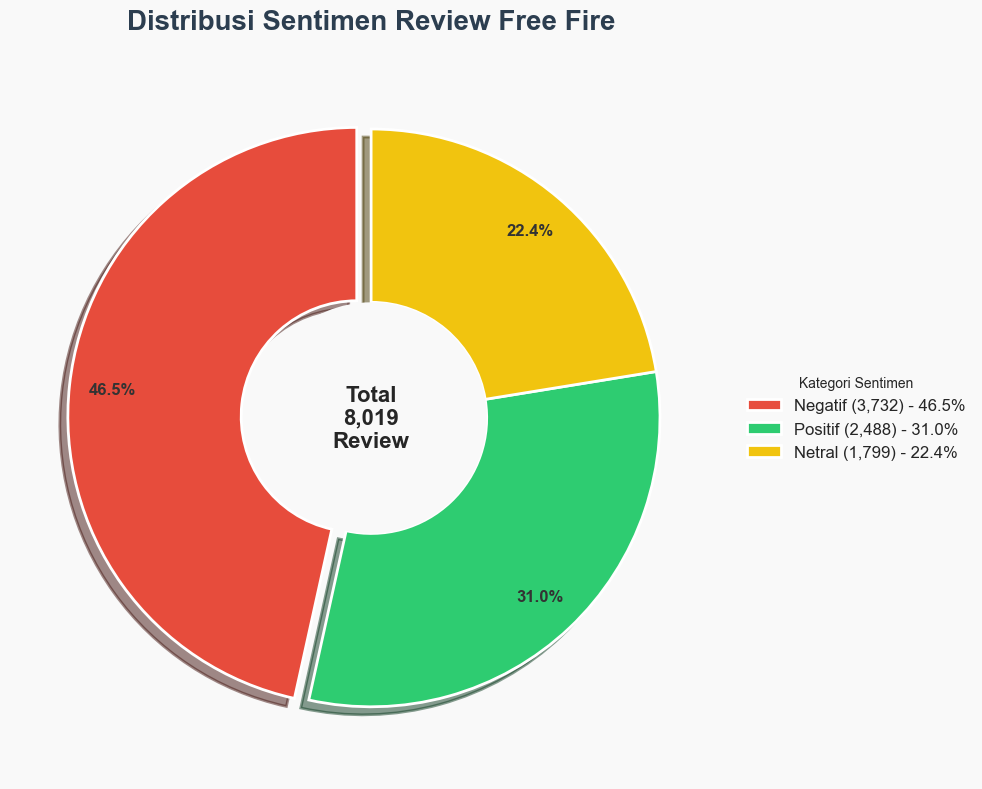

In [22]:
# Setup style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Menyiapkan data untuk visualisasi menggunakan piechart
sentiment_counts = df_clean['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
percentages = [f'{(x/sum(sizes)*100):.1f}%' for x in sizes]

# Ilmu dulu ketika membuat web kita pake wkwk
colors = {
    'positif': '#2ecc71',  # Hijau
    'negatif': '#e74c3c',  # Merah
    'netral': '#f1c40f'    # Kuning
}

# Mengurutkan warna yang sesuai dengan urutan label
color_list = [colors[label] for label in labels]

# Mengatur explode untuk efek visual
explode = [0.05 if label == 'negatif' else 0 for label in labels]

# Membuat subplots
fig, ax = plt.subplots(figsize=(16, 8), facecolor='#f9f9f9')
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=None,  # Hapus labels bawaan
    autopct=lambda pct: f'{pct:.1f}%',
    explode=explode,
    colors=color_list,
    startangle=90,
    shadow=True,
    wedgeprops={'edgecolor': 'white', 'width': 0.6, 'linewidth': 2},
    pctdistance=0.85,
    textprops={'fontsize': 14, 'fontweight': 'bold', 'color': '#333333'}
)

# Menambahkan label ke wedges
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Membuat lubang donat 
centre_circle = plt.Circle((0, 0), 0.4, fc='#f9f9f9')
ax.add_artist(centre_circle)

# Menambahkan judul dan juga styling
ax.set_title('Distribusi Sentimen Review Free Fire', 
             fontsize=20, 
             fontweight='bold', 
             pad=20, 
             color='#2c3e50')

# Menambahkan legend dengan informasi jumlah
legend_labels = [f'{label.capitalize()} ({size:,}) - {pct}' 
                for label, size, pct in zip(labels, sizes, percentages)]
ax.legend(wedges, legend_labels, 
          title='Kategori Sentimen',
          loc='center left', 
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=12)

# Ini pemanis saja sih biar tengah donat nya gak kosong
total_reviews = sum(sizes)
ax.text(0, 0, f'Total\n{total_reviews:,}\nReview', 
        ha='center', va='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.show()

- Bisa kita lihat pada visualisasi pie chart di atas, di temukan bahwa sentiment di dominasi oleh review negatif dengan 46,5% proporsi. dan yang lainnya seperti positif dan juga netral hampir setara cuma selisih 9% doang. Maka dari itu kita simpulkan bahwa aplikasi free fire ini sering mendapatkan komplain dari usernya sendiri dan terbukti sih emang seperti itu pemain free fire rata rata terlalu toxic dan masih anak di bawah umur lagi.

### **Eksplorasi Sentiment**

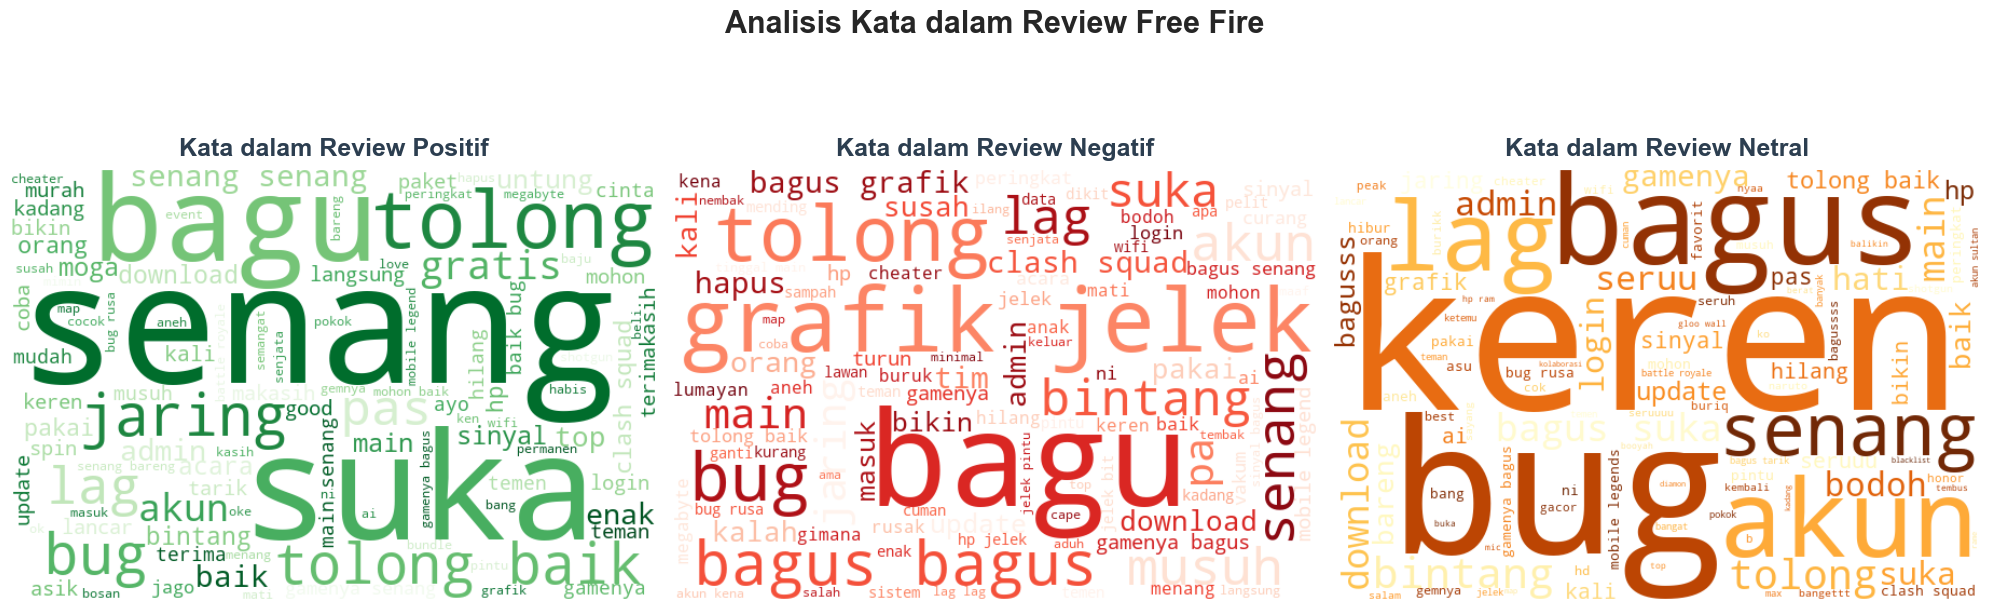

In [23]:
# Kumpulkan teks berdasarkan kategori sentimen
positive_review = ' '.join(df_clean[df_clean['sentiment'] == 'positif']['final_text'].astype(str))
negative_review = ' '.join(df_clean[df_clean['sentiment'] == 'negatif']['final_text'].astype(str))
netral_review = ' '.join(df_clean[df_clean['sentiment'] == 'netral']['final_text'].astype(str))

# Buat figure dengan layout horizontal (1 baris, 3 kolom)
plt.figure(figsize=(20, 7))  # Ukuran yang lebih lebar untuk layout horizontal

# WordCloud untuk sentimen positif (hijau)
plt.subplot(1, 3, 1)  # 1 baris, 3 kolom, posisi 1
pos_cloud = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Greens',  # Warna hijau
    max_words=100,
    contour_width=1,
    contour_color='steelblue'
).generate(positive_review)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.title('Kata dalam Review Positif', fontsize=18, fontweight='bold', color='#2c3e50', pad=10)
plt.axis('off')

# WordCloud untuk sentimen negatif (merah)
plt.subplot(1, 3, 2)  # 1 baris, 3 kolom, posisi 2
neg_cloud = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Reds',  # Warna merah
    max_words=100,
    contour_width=1,
    contour_color='steelblue'
).generate(negative_review)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.title('Kata dalam Review Negatif', fontsize=18, fontweight='bold', color='#2c3e50', pad=10)
plt.axis('off')

# WordCloud untuk sentimen netral (kuning/oranye)
plt.subplot(1, 3, 3)  # 1 baris, 3 kolom, posisi 3
neu_cloud = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='YlOrBr',  # Warna kuning-oranye
    max_words=100,
    contour_width=1,
    contour_color='steelblue'
).generate(netral_review)
plt.imshow(neu_cloud, interpolation='bilinear')
plt.title('Kata dalam Review Netral', fontsize=18, fontweight='bold', color='#2c3e50', pad=10)
plt.axis('off')

# Judul utama
plt.suptitle('Analisis Kata dalam Review Free Fire', fontsize=22, fontweight='bold', y=0.98)

# Atur layout dan simpan
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Menyesuaikan margin untuk judul utama
plt.savefig('sentiment_wordclouds_horizontal.png', dpi=300, bbox_inches='tight')
plt.show()

```
Review Positif
```
- Jika kita lihat kata kata yang sering muncul adalah senang dan suka, ini positif banget sih.
- Terus jika kita lihat ada kata kata bug dan juga tolong, mungkin dia berharap developer nya memperbaiki bug atau masalah yang lainnya secara baik baik, ngasih bintang lah intinya.
- Apalagi kata gratis tuh wkwk itumah fix bocil minta diamond ff itumah buat beli alok.

```
Review Negatif
```
- Untuk yang negatif bisa kita lihat banyak sekali kata kata grafik jelek dan bug, ini menandakan bahwa katanya ff tuh burik, haters kali ini ya.
- Terus meskipun negatif ada juga yang memusi deh aneh bagus tuh memuji terus banyak yang bilang hp jelek, haduh.

```
Review Netral
```
- Kalau ini semuanya pasti ada sih karena ini netral mungkin mereka bilang jelek tapi berharap perbaikan, bilang bagus juga mereka ngerasa jelek game nya atau sistem nya.

# **Data Spliting**

In [27]:
# Menyiapkan data untuk pemodelan
X = df_clean['final_text'] 
y = df_clean['sentiment'] # Feature Dependen (Target)

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Verifikasi ukuran setelah split
print(f'Setelah split - X_train: {len(X_train)}, y_train: {len(y_train)}')
print(f'Setelah split - X_test: {len(X_test)}, y_test: {len(y_test)}')

Setelah split - X_train: 6415, y_train: 6415
Setelah split - X_test: 1604, y_test: 1604


# **Ektrasi Fitur**

## **Menggunakan TF-IDF**

In [28]:
tfidf = TfidfVectorizer(
    max_features = 3000, # Membatasi fitur ke 3000 kata kata paling penting
    min_df = 3, # Mengabaikan kata yang muncul kurang dari 3 dokumen
    max_df = 0.85, # Mengabaikan kata yang muncul di 85% dokumen seperti stopwords
    ngram_range = (1, 3), 
    stop_words = 'english' # Hapus stopwords bahasa inggris karena aku pake bahasa indonesia
)

# Eksekusikan kepada fitur X_train dan juga X_test
Xtrain_tfidf = tfidf.fit_transform(X_train)
Xtest_tfidf = tfidf.transform(X_test)

# Melihat jumlah baris atau review yang di ambil
print(f'Jumlah review yang di ambil oleh TF-IDF data latih  adalah {Xtrain_tfidf.shape}')
print(f'Jumlah review yang di ambil oleh TF-IDF data uji adalah {Xtest_tfidf.shape}')

Jumlah review yang di ambil oleh TF-IDF data latih  adalah (6415, 2374)
Jumlah review yang di ambil oleh TF-IDF data uji adalah (1604, 2374)


## **Menggunakan Bag Of Word (BOW)**

In [29]:
# Inisialisais Code
bow = CountVectorizer(
    max_features = 3000, 
    min_df = 3,
    max_df = 0.85,
    ngram_range = (1, 3),
    stop_words = 'english'
)

# Eksekusi lagi
Xtrain_bow = bow.fit_transform(X_train)
Xtest_bow = bow.transform(X_test)

print(f'Jumlah review yang di ambil oleh BOW data latih  adalah {Xtrain_bow.shape}')
print(f'Jumlah review yang di ambil oleh BOW data uji adalah {Xtest_bow.shape}')

Jumlah review yang di ambil oleh BOW data latih  adalah (6415, 2374)
Jumlah review yang di ambil oleh BOW data uji adalah (1604, 2374)


# **Pelatihan Model**

- Bisa kita lihat bahwa **`SDG Classifier`** lebih baik dari apapun, jika kita lihat dari 

In [82]:
# Menyimpan para model ke dalam list
models = [
    LogisticRegression(random_state=15),
    LinearSVC(random_state=15),
    SGDClassifier(random_state=15),
    MultinomialNB(),
    RandomForestClassifier(random_state=15),
    DecisionTreeClassifier(random_state=15)
]

# Menyimpan fitur ke dalam dictionary
features = {
    'TF-IDF': (Xtrain_tfidf, Xtest_tfidf, y_train, y_test),
    'BOW': (Xtrain_bow, Xtest_bow, y_train, y_test)
}

# Distribusi data yang di inginkan
distributions = ['80/20', '70/30']

# DataFrame hasil buat list untuk menyimpan hasil
results_list = []

print('MEMULAI PELATIHAN MODEL')
print('=' * 60)

total_start_time = time.time()

for feature_name, (X_train_feat, X_test_feat, y_train_feat, y_test_feat) in features.items():
    print(f'\nEKSTRAKSI FITUR: {feature_name}')
    print('-' * 40)
    
    for distribution in distributions:
        print(f'\nDISTRIBUSI DATA: {distribution}')
        
        # Membuat split baru karena ada distribusi yang tidak di undang
        if distribution == '80/20':
            X_tr, X_te, y_tr, y_te = X_train_feat, X_test_feat, y_train_feat, y_test_feat
        else:
            # Split 70/30 dari data original
            X_temp = df_clean['final_text']
            y_temp = df_clean['sentiment']
            X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
                X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
            )
            
            if feature_name == 'TF-IDF':
                X_tr = tfidf.transform(X_train_temp)
                X_te = tfidf.transform(X_test_temp)
            else:  # BOW
                X_tr = bow.transform(X_train_temp)
                X_te = bow.transform(X_test_temp)
            
            y_tr, y_te = y_train_temp, y_test_temp
        
        print(f'Train samples: {X_tr.shape[0]}, Test samples: {X_te.shape[0]}')
        
        for model in models:
            model_name = model.__class__.__name__
            
            try:
                print(f'Training {model_name:25}', end=' ')
                
                # Start Time 
                start_time = time.time()
                
                # Training model
                model.fit(X_tr, y_tr)
                
                # Prediksi
                y_train_pred = model.predict(X_tr)
                y_test_pred = model.predict(X_te)
                
                # Evaluasi Model
                train_acc = accuracy_score(y_tr, y_train_pred)
                test_acc = accuracy_score(y_te, y_test_pred)
                precision = precision_score(y_te, y_test_pred, average='weighted')
                recall = recall_score(y_te, y_test_pred, average='weighted')
                f1 = f1_score(y_te, y_test_pred, average='weighted')
                
                # Hitung waktu training
                train_time = time.time() - start_time
                
                # Simpan hasil ke list
                results_list.append({
                    'Model': model_name,
                    'Ekstraksi Fitur': feature_name,
                    'Distribusi Data': distribution,
                    'Akurasi Train': round(train_acc, 4),
                    'Akurasi Test': round(test_acc, 4),
                    'Precision': round(precision, 4),
                    'Recall': round(recall, 4),
                    'F1-Score': round(f1, 4),
                    'Waktu (s)': round(train_time, 2)
                })
                
                print(f'Success (Akurasi: {test_acc:.4f}, Waktu: {train_time:.2f}s)')
                
            except Exception as e:
                print(f'Error: {str(e)}')
                
                # Simpan error ke list
                results_list.append({
                    'Model': model_name,
                    'Ekstraksi Fitur': feature_name,
                    'Distribusi Data': distribution,
                    'Akurasi Train': None,
                    'Akurasi Test': None,
                    'Precision': None,
                    'Recall': None,
                    'F1-Score': None,
                    'Waktu (s)': None
                })

# Buat DataFrame dari list
results_df = pd.DataFrame(results_list)

# Hasil akhir
total_time = time.time() - total_start_time
print('\n' + '=' * 60)
print('TRAINING SELESAI')
print(f'Total waktu eksekusi: {total_time:.2f} detik')
print(f'Eksperimen berhasil: {len(results_df[results_df["Akurasi Test"].notna()])}')
print(f'Eksperimen gagal: {len(results_df[results_df["Akurasi Test"].isna()])}')

print('\nHASIL PELATIHAN MODEL:')
print('=' * 60)
results_df

MEMULAI PELATIHAN MODEL

EKSTRAKSI FITUR: TF-IDF
----------------------------------------

DISTRIBUSI DATA: 80/20
Train samples: 5613, Test samples: 2406
Training LogisticRegression        Success (Akurasi: 0.8591, Waktu: 0.12s)
Training LinearSVC                 Success (Akurasi: 0.8766, Waktu: 0.05s)
Training SGDClassifier             Success (Akurasi: 0.8782, Waktu: 0.04s)
Training MultinomialNB             Success (Akurasi: 0.7244, Waktu: 0.03s)
Training RandomForestClassifier    Success (Akurasi: 0.8570, Waktu: 2.39s)
Training DecisionTreeClassifier    Success (Akurasi: 0.8275, Waktu: 0.27s)

DISTRIBUSI DATA: 70/30
Train samples: 5613, Test samples: 2406
Training LogisticRegression        Success (Akurasi: 0.8637, Waktu: 0.09s)
Training LinearSVC                 Success (Akurasi: 0.8736, Waktu: 0.05s)
Training SGDClassifier             Success (Akurasi: 0.8799, Waktu: 0.04s)
Training MultinomialNB             Success (Akurasi: 0.7552, Waktu: 0.03s)
Training RandomForestClassifier 

,Model,Ekstraksi Fitur,Distribusi Data,Akurasi Train,Akurasi Test,Precision,Recall,F1-Score,Waktu (s)
0,LogisticRegression,TF-IDF,80/20,0.9364,0.8591,0.8605,0.8591,0.8592,0.12
1,LinearSVC,TF-IDF,80/20,0.9781,0.8766,0.8766,0.8766,0.8766,0.05
2,SGDClassifier,TF-IDF,80/20,0.9708,0.8782,0.8783,0.8782,0.8782,0.04
3,MultinomialNB,TF-IDF,80/20,0.8496,0.7244,0.7701,0.7244,0.6882,0.03
4,RandomForestClassifier,TF-IDF,80/20,0.9991,0.8570,0.8611,0.8570,0.8577,2.39
5,DecisionTreeClassifier,TF-IDF,80/20,0.9991,0.8275,0.8321,0.8275,0.8281,0.27
6,LogisticRegression,TF-IDF,70/30,0.9271,0.8637,0.8645,0.8637,0.8639,0.09
7,LinearSVC,TF-IDF,70/30,0.9676,0.8736,0.8759,0.8736,0.8743,0.05
8,SGDClassifier,TF-IDF,70/30,0.9546,0.8799,0.8817,0.8799,0.8804,0.04
9,MultinomialNB,TF-IDF,70/30,0.8147,0.7552,0.7704,0.7552,0.7345,0.03


- Waduh ini model nya terlalu banyak deh yang aku pake bisa bisa nya sampai mudal seperti ini, kita bakal menggunakan kode buat nyari model terbaik saja deh biar gak bingung.

In [85]:
# Analisis hasil terbaik
successful_results = results_df[results_df['Akurasi Test'].notna()].copy()

if len(successful_results) > 0:
    print('\nTOP 5 MODEL TERBAIK:')
    print('=' * 50)
    top_3 = successful_results.nlargest(3, 'Akurasi Test')[
        ['Model', 'Ekstraksi Fitur', 'Distribusi Data', 'Akurasi Test', 'F1-Score', 'Waktu (s)']
    ]
    display(top_3)
    
    # Model terbaik
    best_idx = successful_results['Akurasi Test'].idxmax()
    best_model = successful_results.loc[best_idx]
    print(f'\nMODEL TERBAIK:')
    print(f'Model: {best_model["Model"]}')
    print(f'Ekstraksi Fitur: {best_model["Ekstraksi Fitur"]}')
    print(f'Distribusi Data: {best_model["Distribusi Data"]}')
    print(f'Akurasi Test: {best_model["Akurasi Test"]}')
    print(f'F1-Score: {best_model["F1-Score"]}')
    print(f'Waktu Training: {best_model["Waktu (s)"]} detik')
    
    # Rata-rata per model
    print(f'\nRATA-RATA PERFORMA PER MODEL:')
    avg_performance = successful_results.groupby('Model')[['Akurasi Test', 'F1-Score']].mean().round(4)
    avg_performance = avg_performance.sort_values('Akurasi Test', ascending=False)
    display(avg_performance)
    
else:
    print('Tidak ada eksperimen yang berhasil')

print('\nANALISIS SELESAI')


TOP 5 MODEL TERBAIK:


,Model,Ekstraksi Fitur,Distribusi Data,Akurasi Test,F1-Score,Waktu (s)
20,SGDClassifier,BOW,70/30,0.8869,0.8876,0.05
19,LinearSVC,BOW,70/30,0.8840,0.8851,0.08
14,SGDClassifier,BOW,80/20,0.8828,0.8839,0.04



MODEL TERBAIK:
Model: SGDClassifier
Ekstraksi Fitur: BOW
Distribusi Data: 70/30
Akurasi Test: 0.8869
F1-Score: 0.8876
Waktu Training: 0.05 detik

RATA-RATA PERFORMA PER MODEL:


,Akurasi Test,F1-Score
Model,,
SGDClassifier,0.8820,0.8825
LinearSVC,0.8783,0.8790
LogisticRegression,0.8632,0.8638
RandomForestClassifier,0.8535,0.8541
DecisionTreeClassifier,0.8332,0.8337
MultinomialNB,0.7420,0.7175



ANALISIS SELESAI
